In [ ]:
from zipfile import ZipFile
import requests


def download(url, local_filepath):
    r = requests.get(url)
    with open(local_filepath, "wb") as f:
        f.write(r.content)
    return local_filepath

dummy_dataset_url = "https://hf.co/datasets/sayakpaul/sample-datasets/resolve/main/sample-imagenet-images.zip"
local_filepath = download(dummy_dataset_url, dummy_dataset_url.split("/")[-1])

with ZipFile(local_filepath, "r") as zipper:
    zipper.extractall(".")

In [ ]:
from PIL import Image
import os
import numpy as np

dataset_path = "sample-imagenet-images"
image_paths = sorted([os.path.join(dataset_path, x) for x in os.listdir(dataset_path)])

real_images = [np.array(Image.open(path).convert("RGB")) for path in image_paths]

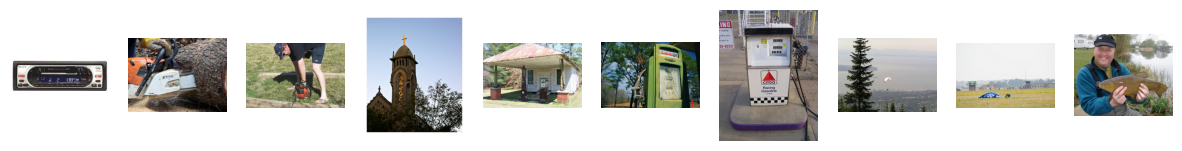

In [ ]:
import matplotlib.pyplot as plt

# Display the first few images
num_images_to_display = 10
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))

for i in range(num_images_to_display):
    axes[i].imshow(real_images[i])
    axes[i].axis('off')

plt.show()

In [ ]:
from torchvision.transforms import functional as F
import torch

def preprocess_image(image):
    image = torch.tensor(image).unsqueeze(0)
    image = image.permute(0, 3, 1, 2) / 255.0
    return F.center_crop(image, (256, 256))

real_images = torch.cat([preprocess_image(image) for image in real_images])
print(real_images.shape)
# torch.Size([10, 3, 256, 256])

torch.Size([10, 3, 256, 256])


In [ ]:
!pip install diffusers

import torch
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import make_image_grid, load_image

# Initialize the pipeline
pipe = AutoPipelineForImage2Image.from_pretrained(
    "stabilityai/sd-turbo", torch_dtype=torch.float16, variant="fp16"
).to("cuda")

# Your list of prompts
words = [
    "cassette player",
    "chainsaw",
    "chainsaw 1",
    "church",
    "gas pump",
    "gas pump 1",
    "gas pump 2",
    "parachute",
    "parachute 1",
    "tench",
]

real_images = real_images.to('cuda')

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/1 [00:00<?, ?it/s]

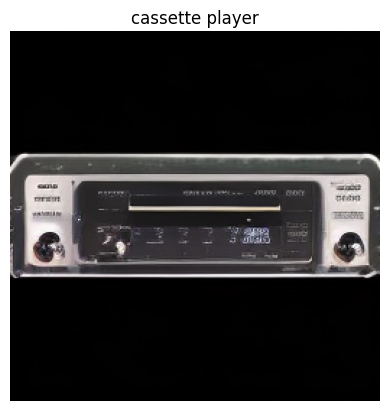

  0%|          | 0/1 [00:00<?, ?it/s]

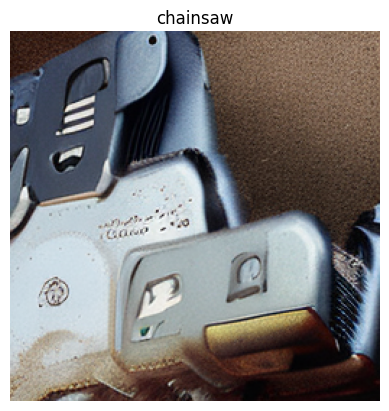

  0%|          | 0/1 [00:00<?, ?it/s]

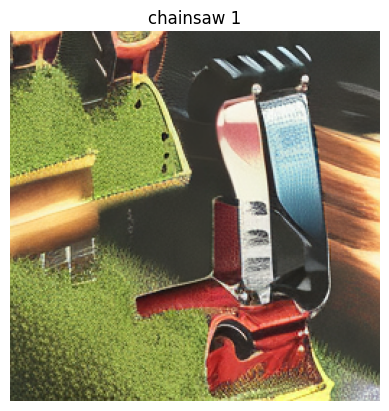

  0%|          | 0/1 [00:00<?, ?it/s]

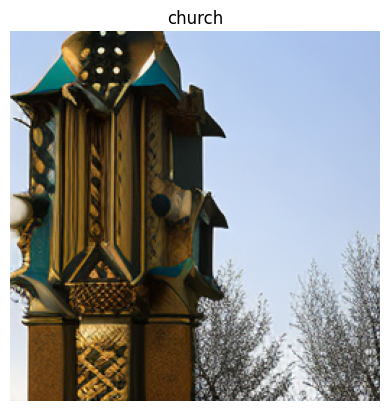

  0%|          | 0/1 [00:00<?, ?it/s]

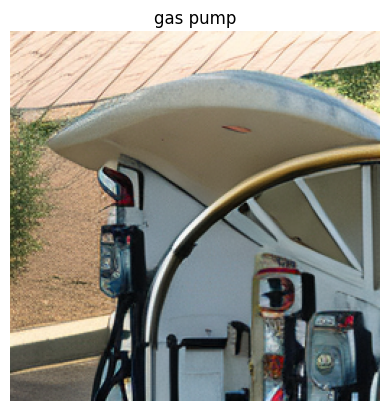

  0%|          | 0/1 [00:00<?, ?it/s]

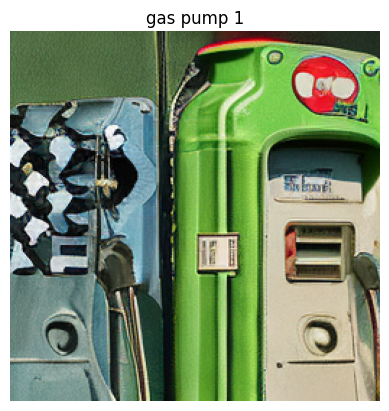

  0%|          | 0/1 [00:00<?, ?it/s]

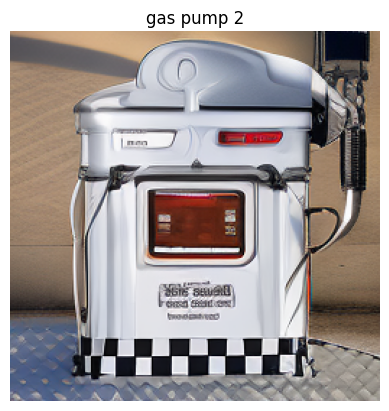

  0%|          | 0/1 [00:00<?, ?it/s]

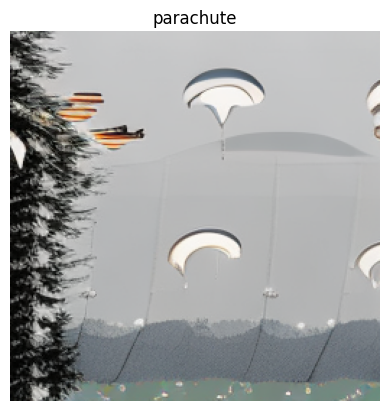

  0%|          | 0/1 [00:00<?, ?it/s]

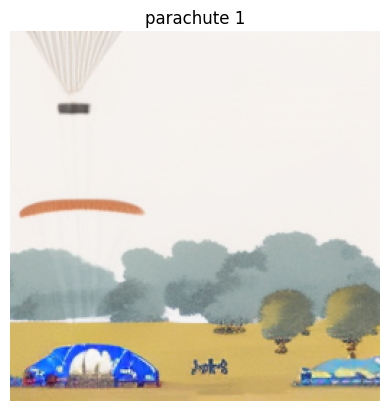

  0%|          | 0/1 [00:00<?, ?it/s]

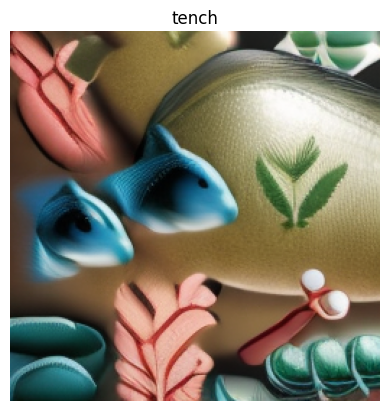

In [ ]:
from torchvision import transforms

# Directory to save the generated images
generated_dir = './generated_images/'
os.makedirs(generated_dir, exist_ok=True)

# Function to convert tensor to image
to_pil_image = transforms.ToPILImage()
to_tensor = transforms.ToTensor()

# List to store the paths to the generated images
generated_image_paths = []

# Loop through prompts and generate images
for i, prompt in enumerate(words):
    # Pass the prompt and image to the pipeline
    generated_image = pipe(prompt, image=real_images[i], num_inference_steps=2, strength=0.5, guidance_scale=0.0).images[0]

    # Convert the tensor to a PIL Image

    generated_image_tensor = to_tensor(generated_image)
    pil_image = to_pil_image(generated_image_tensor)

    # Save the PIL Image to the directory
    image_path = os.path.join(generated_dir, f"{prompt}_generated.png")
    pil_image.save(image_path)

    # Add the path to the list
    generated_image_paths.append(image_path)

    # Display the image
    plt.imshow(pil_image)
    plt.title(prompt)
    plt.axis('off')
    plt.show()

In [ ]:
!pip install pytorch-fid torchvision

import os
from PIL import Image
from pytorch_fid.fid_score import calculate_fid_given_paths

def load_images(path):
    images = []
    for filename in os.listdir(path):
        img = Image.open(os.path.join(path, filename))
        if img is not None:
            images.append(img)
    return images

path1 = "/content/sample-imagenet-images"
path2 = "/content/generated_images"

images1 = load_images(path1)
images2 = load_images(path2)

In [ ]:
paths = []
paths.append(path1)
paths.append(path2)

fid_score = calculate_fid_given_paths(paths, batch_size=1, device='cpu', dims=2048)
print("FID Score:", fid_score)

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 127MB/s]
100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


ValueError: Imaginary component 6.386148347821629e+108

#issue mainly arising due to small number of images